# tweet-sentiment with DistilBERT

In this notebook, we analyse the tweet-sentiment dataset with Google's DistilBERT model. This is a distilled version of the original BERT model, and it promises to be "smaller, faster, cheaper, and lighter" than BERT. Below is a comparison of *distilbert-base-uncased* against the full *bert-base-uncased* as measured on the GLUE language understanding benchmark: 
- 40% fewer parameters; 
- runs 60% faster; 
- preserves over 95% of *bert-base-uncased*'s performance. 

Please note that this notebook and the BERT notebook are identical except in choice of model and tokenizer. 

## 0. Set-up

The first step is to load all the necessary libraries. For this project, we use the pretrained models and tokenizers provided in the Transformers library. 

In [3]:
!pip install transformers 

import numpy as np 
import pandas as pd 
import tensorflow as tf
import torch 

from sklearn.model_selection import train_test_split 

from torch.utils.data import TensorDataset, random_split 
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, BertConfig
from transformers import get_linear_schedule_with_warmup, AdamW

import matplotlib.pyplot as plt
import seaborn as sns

import time 
import datetime
import random

     |████████████████████████████████| 573kB 4.9MB/s 
     |████████████████████████████████| 1.0MB 19.7MB/s 
     |████████████████████████████████| 3.7MB 37.1MB/s 
     |████████████████████████████████| 890kB 35.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=fa3bb72b7566abe28e2eeec873e0abc276dfa7d84cb360f2a812d45ae10e38ee
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


For reproducibility purposes we also fix a seed value of 42 throughout the project. 

In [1]:
seed = 42

In [5]:
# check for GPU 
device_name = tf.test.gpu_device_name()

if device_name == "/device:GPU:0":
  print("Found GPU at {}".format(device_name))
else:
  raise SystemError("GPU device not found")
  
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("There are {} GPU(s) available".format(torch.cuda.device_count()))
  print("We will use the GPU", torch.cuda.get_device_name(0))
else: 
  device = torch.device("cpu")
  print("No GPU available, we use the CPU instead")

Found GPU at /device:GPU:0
There are 1 GPU(s) available
We will use the GPU Tesla P100-PCIE-16GB


## 1. Load the Dataset

Using the functions defined in our eda module, we load and do simple cleaning of the dataset. This includes: 
- removing NA values; 
- converting the categorical variable `sentiment` to numerical values. 

The functions `load_dataset` and `clean_data` are copied from the eda module because of importing difficulties when using Google Colab to run the notebook.

In [0]:
def load_dataset(url):
    # load dataset 
    dat = pd.read_csv(url)
    return pd.DataFrame(data=dat, columns=["text", "sentiment"])

def clean_dataset(df):
    # convert sentiment (categorical) to label (numerical)
    # negative = 0, neutral = 1, positive = 2
    df["sentiment"]  = df.sentiment.map({"negative": 0, "neutral": 1, "positive": 2}) 

    # remove missing values 
    df = df[df.text.notna()]
    return df

In [7]:
df = load_dataset(url="https://raw.github.com/ant1code/tweet-sentiment/master/data/train.csv")

# clean the data: remove na, convert categorical to numerical
df = clean_dataset(df)

print(f"This dataset consists of {len(df)} tweets.")
df.head()

This dataset consists of 27485 tweets.


,text,sentiment
0,Spent the entire morning in a meeting w/ a ven...,1
1,Oh! Good idea about putting them on ice cream,2
2,says good (or should i say bad?) afternoon! h...,1
3,i dont think you can vote anymore! i tried,0
4,haha better drunken tweeting you mean?,2


## 2. Data Processing 

We have already verified that the dataset is balanced, so we go straight into the processing of the data. Note that for BERT models (and its variants), there are very specific formatting requirements for the input: 
- all tweets must have (or be padded to) the same length; 
- all tweets require special tokens to separate sentences and for padding; 
- each tweet has an *attention mask* that indicates where real tokens end and padding tokens begin. 

This part is somewhat involved, so we first work with the following made-up tweet to explain the details. 

In [0]:
tweet = "I'm in LOVE with this game! It makes me happy @nintendo" 

The first step is to load a pretrained DistilBERT tokenizer: 

In [9]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased") 

Using this tokenizer, we can convert the words in our tweet to tokens, then assign unique integers (token ids) to these tokens: 

In [10]:
tokens = tokenizer.tokenize(tweet)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f"Text: {tweet}")
print(f"Tokens: {tokens}")
print(f"Token IDs: {token_ids}")

Text: I'm in LOVE with this game! It makes me happy @nintendo
Tokens: ['i', "'", 'm', 'in', 'love', 'with', 'this', 'game', '!', 'it', 'makes', 'me', 'happy', '@', 'nintendo']
Token IDs: [1045, 1005, 1049, 1999, 2293, 2007, 2023, 2208, 999, 2009, 3084, 2033, 3407, 1030, 10022]


The next step is to add special tokens to the tweet. These special tokens (and their token ids) are: 
- `[CLS], 101`: to specify the start of a sentence and to tell DistilBERT that we are doing classification
- `[SEP], 102`: to specify the end of a sentence 
- `[PAD], 0`  : used to pad all tweets to the same length 

This step can be accomplished easily with the help of the `encode_plus()` method like so: 

In [11]:
encoded_dict = tokenizer.encode_plus(
    tweet, add_special_tokens=True, max_length=20, 
    pad_to_max_length=True
)

print(encoded_dict["input_ids"])

[101, 1045, 1005, 1049, 1999, 2293, 2007, 2023, 2208, 999, 2009, 3084, 2033, 3407, 1030, 10022, 102, 0, 0, 0]


The final step is to make an attention mask for the tokenized tweet, which is a list of zeros and ones that represent whether or not the respective token is a real token or a padding token. This can also be done with the `encode_plus` function: 

In [12]:
encoded_dict = tokenizer.encode_plus(
    tweet, add_special_tokens=True, max_length=20, 
    pad_to_max_length=True, return_attention_mask=True
)

print(encoded_dict["input_ids"])
print(encoded_dict["attention_mask"])

[101, 1045, 1005, 1049, 1999, 2293, 2007, 2023, 2208, 999, 2009, 3084, 2033, 3407, 1030, 10022, 102, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]


The tokenization of a single tweet is a simple process. however when dealing with an entire dataset, it is important to have a suitable value for the `max_length` parameter; once fixed, Bert (and its variants) will only be able to work with sequences with no more than `max_length` many tokens. 

Let us plot the distribution of number of tokens in the entire dataset: 

In [13]:
token_lengths = []

max_tokens = 0
count_more_than_80 = 0
for text in df.text: 
    tokens = tokenizer.encode(text, max_length=160)
    n = len(tokens)
    token_lengths.append(n)
    
    if n > 80: count_more_than_80 += 1
    if n > max_tokens: max_tokens = n
    
print(f"The highest number of tokens in the entire dataset is {max_tokens}.")
print(f"There are {count_more_than_80} tweets with more than 80 tokens.")

The highest number of tokens in the entire dataset is 110.
There are 2 tweets with more than 80 tokens.


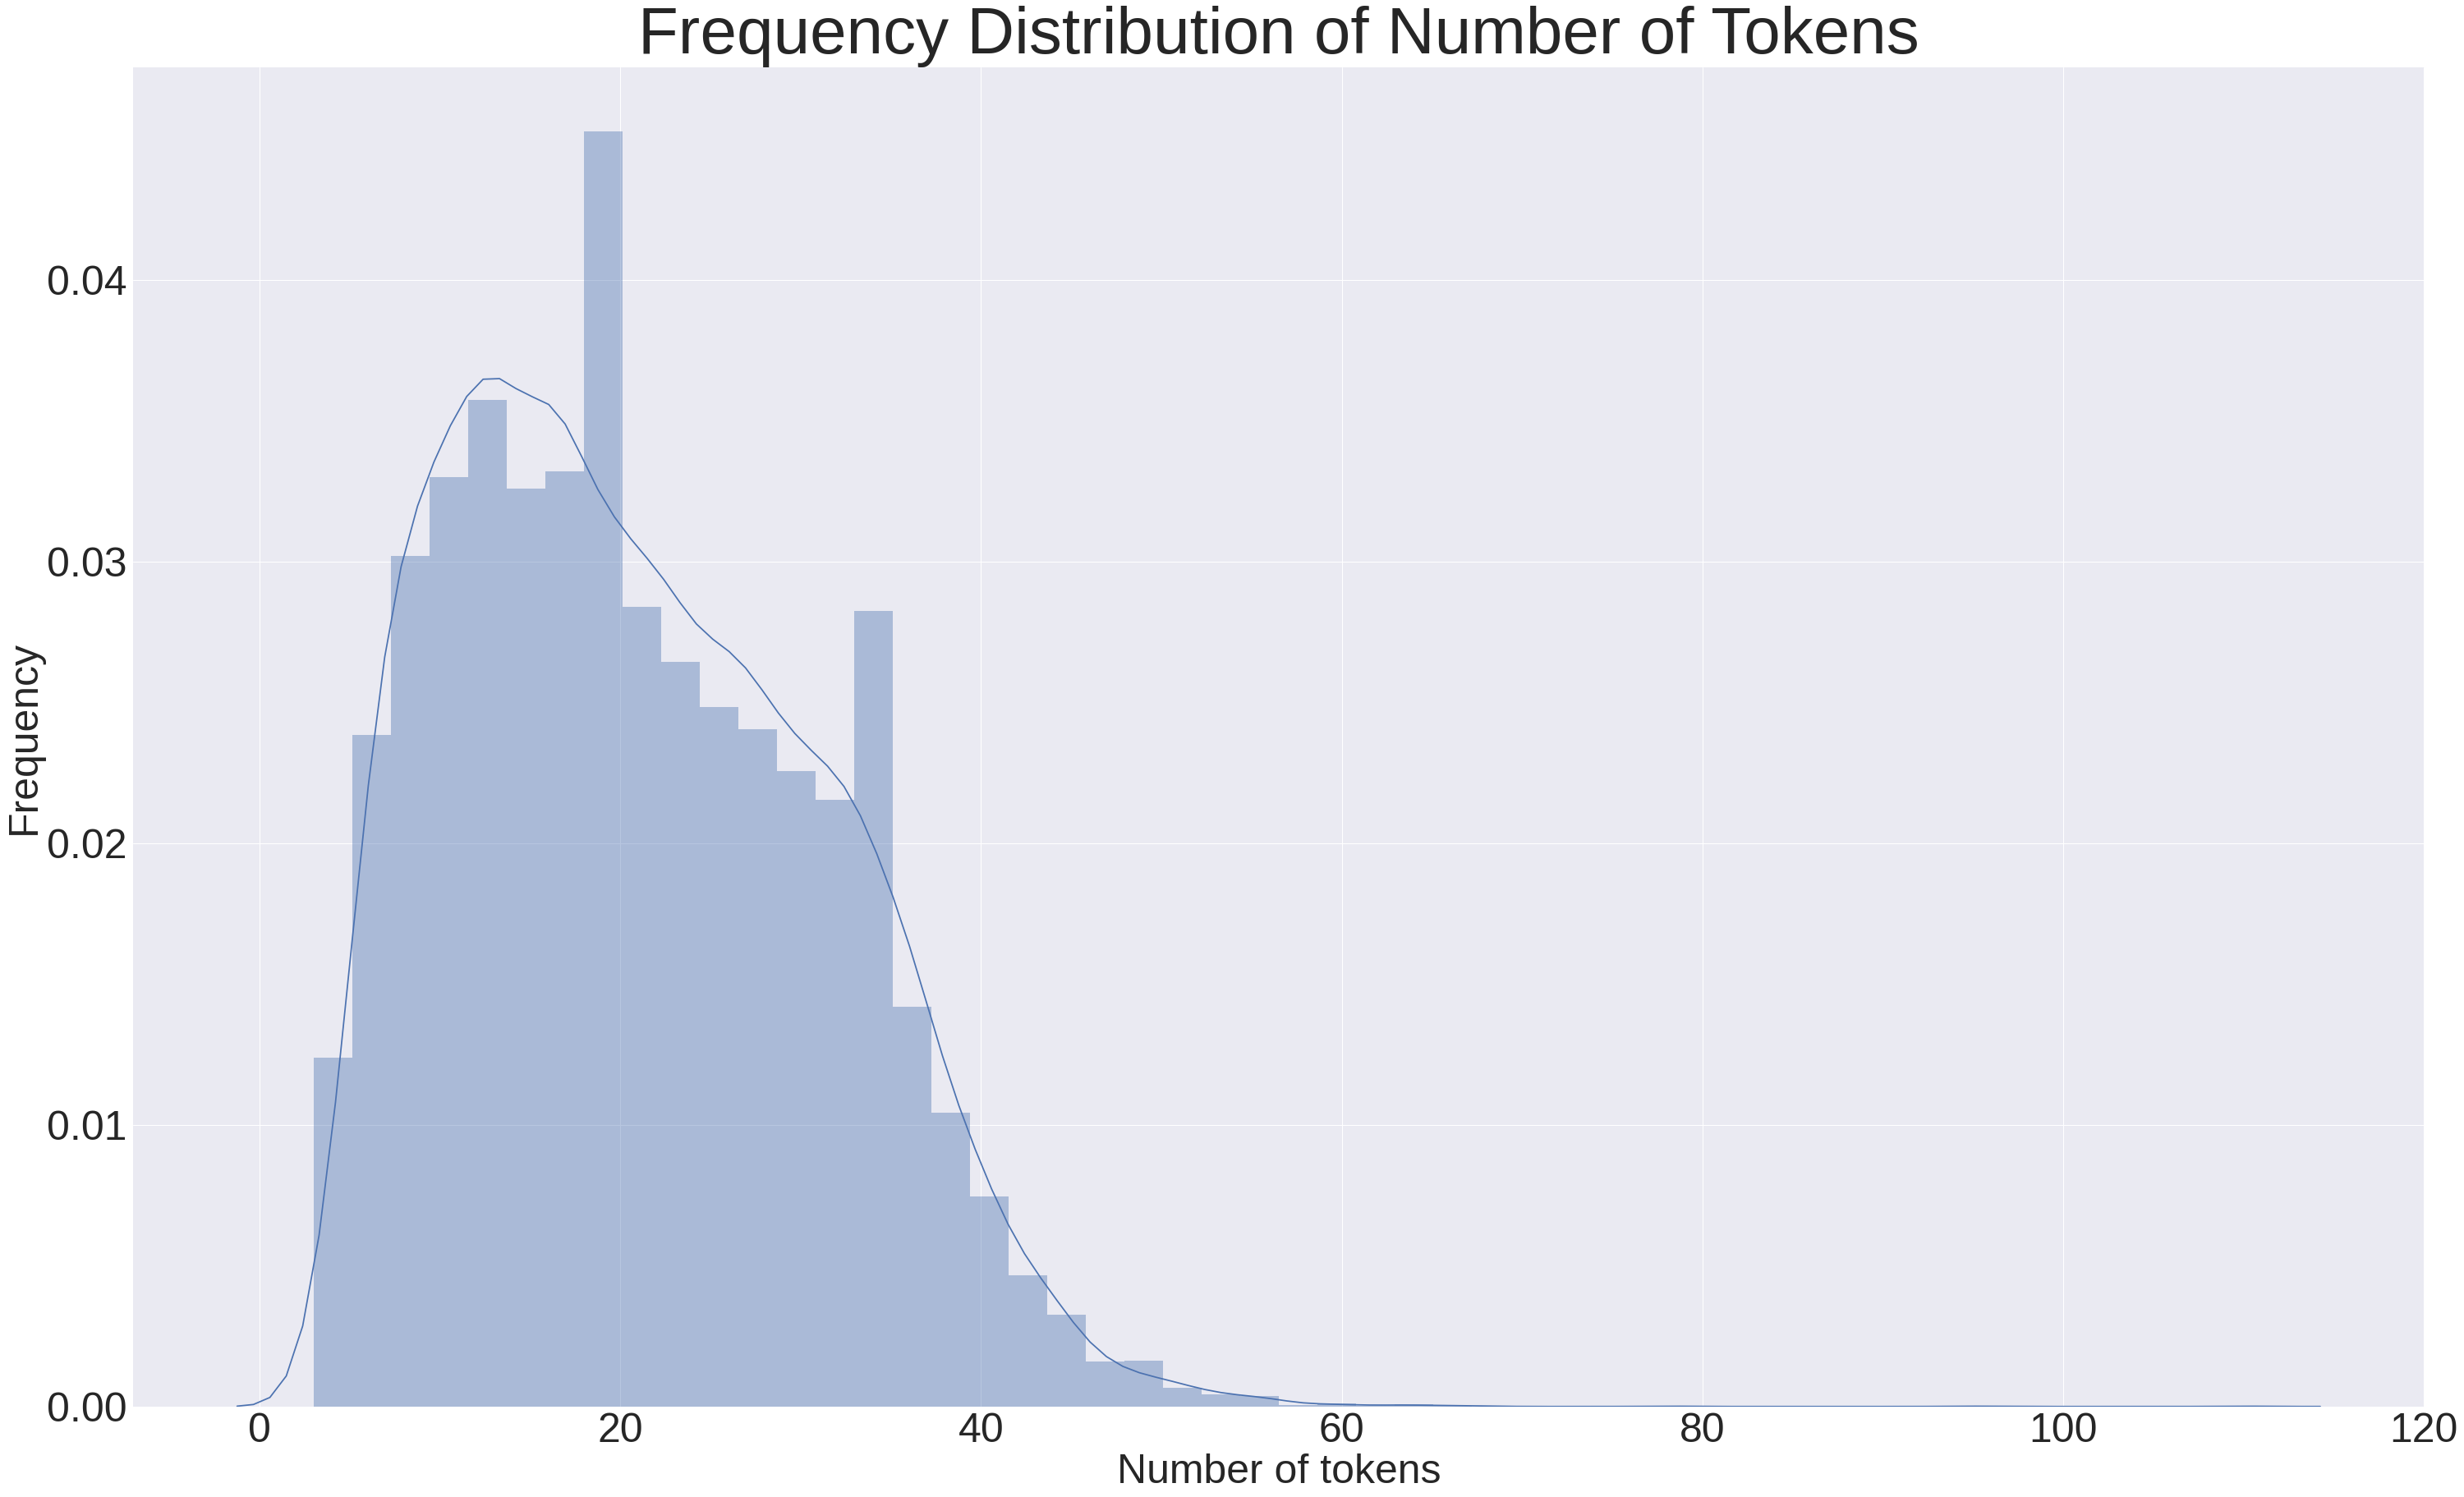

In [14]:
# plot token lengths 
plt.style.use(["seaborn"])
plt.figure(figsize=(50,30))

sns.distplot(token_lengths)

plt.title("Frequency Distribution of Number of Tokens", fontsize=80)
plt.xlabel("Number of tokens", fontsize=50)
plt.xticks(fontsize=50)
plt.ylabel("Frequency", fontsize=50)
plt.yticks(fontsize=50)

plt.show()

Most tweets have fewer than 60 tokens, but there are two tweets with more than 80 tokens, and the highest number of tokens is 110. To avoid changing the dataset too much we leave the dataset as-is. For future projects, removing these two tweets may be a good idea as the resulting DistilBert model would be smaller and less complex, and fewer padding tokens would be needed. 

Having analysed our dataset, we can safely set a maximum length of 120 tokens (to be on the safe side) and proceed with tokenizing all tweets. 

In [0]:
token_ids = [] 
attention_masks = []

for text in df.text:
  encoded_dict = tokenizer.encode_plus(
      text, add_special_tokens=True, max_length=120,
      pad_to_max_length=True, return_attention_mask=True, return_tensors="pt"
  )

  token_ids.append(encoded_dict["input_ids"])
  attention_masks.append(encoded_dict["attention_mask"])

In [0]:
# create torch tensors size(train_set) x max_length
token_ids = torch.cat(token_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

Now that all data preprocessing is complete, it remains to split the dataset into train, validation, and test sets. We also make use of data loaders, which help reduce RAM usage by loading data in batches instead of all at once. 

In [17]:
labels = torch.tensor(df.sentiment.values) 
dataset = TensorDataset(token_ids, attention_masks, labels)

# split into train, validation, test sets (60-20-20)
train_dataset, remainder = train_test_split(dataset, test_size=0.4, random_state=seed)
valid_dataset, test_dataset = train_test_split(remainder, test_size=0.5, random_state=seed)

print(f"The training, validation, and testing sets consist of {len(train_dataset)}, {len(valid_dataset)}, and {len(test_dataset)} tweets respectively.")

The training, validation, and testing sets consist of 16491, 5497, and 5497 tweets respectively.


In [0]:
# create train, validation, test dataloaders
batch_size = 32

train_dataloader = DataLoader(
    train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size
)

valid_dataloader = DataLoader(
    valid_dataset, sampler=SequentialSampler(valid_dataset), batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size
)

## 4. Fine-Tuning DistilBERT

The main point of this part is the training loop, which is used to fine-tune a pretrained DistilBERT model to our dataset. 

In [19]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=3, output_attentions=False, output_hidden_states=False
)

The following command puts the model on the current GPU device, which was set at the beginning of this notebook. Doing this allows us to make use of sophisticated parallel computing architecture to speed up computations and therefore train the model more efficiently. 

In [20]:
model.cuda()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

Before going into the fine-tuning process, we have to take care of a few more details, namely: 
- loss function 
- optimization algorithm 
- scheduler

The choice of loss function is straightforward; since the problem is one of classification, we can simply use the accuracy of predictions as a loss function: 

In [0]:
def flat_accuracy(logits, labels):
  # let prediction be the logit with highest value 
  pred_flat = np.argmax(logits, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

Next, we choose an optimization algorithm, which are meant to help in minimizing the loss function. There are many good algorithms to choose from, but for this project, we opt for a variant of the well-known Adam optimization algorithm that is known to be suitable for fine-tuning models:  

In [0]:
optimizer = AdamW(
    model.parameters(), lr=2e-5, eps=1e-8
) 

For the scheduler, we choose a linear schedule with warmup steps. The idea is that initial steps should be large because it is unlikely that we start near the minima, but as time goes on and we approach the minima, the steps taken should be smaller so that we can converge towards it. 

As recommended by the authors of Bert, the number of epochs is set to 3. (It turns out that even just 3 epochs results in overfitting of the model, and ultimately we will only fine-tune over 2 epochs.)

In [0]:
n_epochs = 3
total_steps = len(train_dataloader) * n_epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

We are finally ready for fine-tuning the DistilBERT model on our dataset! This involves: 
- letting the model train on the train set; 
- evaluating the model on the validation set;
- repeating the above for 2 more epochs

In [0]:
# for nicer formatting
def format_time(elapsed):
  elapsed_rounded = int(round(elapsed)) 
  return str(datetime.timedelta(seconds=elapsed_rounded))

# for reproducibility purposes 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [25]:
# main training loop 
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, n_epochs): 
  print("")
  print("=============== Epoch {:} / {:} ===============".format(epoch_i+1, n_epochs))
  print("Training...")

  t0 = time.time()
  total_train_loss = 0

  # put model in training mode 
  model.train() 
  
  for step, batch in enumerate(train_dataloader):
    # unpack input and labels 
    b_input_ids  = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels     = batch[2].to(device)

    # clear previously calculated gradients - must be done before backward pass! 
    model.zero_grad()

    # forward pass to evaluate model on this batch 
    loss, logits = model(
        input_ids      = b_input_ids, 
        attention_mask = b_input_mask, 
        labels         = b_labels.long() 
    ) 

    # increment by this batch's training loss 
    total_train_loss += loss.item() 

    # backward pass to calculate gradients 
    loss.backward() 

    # limit gradients to 1.0 to avoid infinite gradients 
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters (according to optimizer) 
    optimizer.step() 
    
    # update learning rate (according to scheduler)
    scheduler.step() 

    # print training progress every 100 batches 
    if step % 100 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print("  batch {:>5,} of {:>5,};    elapsed: {:}".format(step, len(train_dataloader), elapsed))

  # average training loss for this epoch 
  avg_train_loss = total_train_loss / len(train_dataloader)
  
  # time taken for training in this epoch
  training_time = format_time(time.time() - t0)

  print("")
  print("  average training loss: {0:.2f}".format(avg_train_loss))
  print("  time taken for training: {:}".format(training_time))

  print("")
  print("Running validation...")

  t0 = time.time() 
  total_eval_accuracy = 0
  total_eval_loss = 0 
  nb_eval_steps = 0 

  # put model in evaluation mode
  model.eval()

  for batch in valid_dataloader: 
    # unpack input and labels 
    b_input_ids  = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels     = batch[2].to(device).long()

    # disable gradient calculation, since there are no backward passes 
    with torch.no_grad(): 
      # forward pass to evaluate model on this batch 
      loss, logits = model(
          b_input_ids, attention_mask=b_input_mask, labels=b_labels
      ) 
    
    # increment by this batch's validation loss 
    total_eval_loss += loss.item()

    # move logits and labels to cpu 
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to("cpu").numpy()

    total_eval_accuracy += flat_accuracy(logits, label_ids)

  # average validation statistics for this epoch
  avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
  avg_val_loss = total_eval_loss / len(valid_dataloader)
  valid_time = format_time(time.time() - t0)
  print("  accuracy: {0:.2f}".format(avg_val_accuracy))
  print("  validation loss: {0:.2f}".format(avg_val_loss))
  print("  time taken for validation: {:}".format(valid_time))
  
  valid_time = format_time(time.time() - t0)

  # record this epoch's train/validation statistics
  training_stats.append(
      {
          "epoch": epoch_i+1, 
          "training loss": avg_train_loss, 
          "valid. loss": avg_val_loss, 
          "valid. accuracy": avg_val_accuracy, 
          "training time": training_time, 
          "valid. time": valid_time
      }
  )

print("")
print("Training is complete.")
print("Training time: {:}".format(format_time(time.time() - total_t0)))


=============== Epoch 1 / 3 ===============
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  batch   100 of   516;    elapsed: 0:00:19
  batch   200 of   516;    elapsed: 0:00:38
  batch   300 of   516;    elapsed: 0:00:56
  batch   400 of   516;    elapsed: 0:01:15
  batch   500 of   516;    elapsed: 0:01:33

  average training loss: 0.64
  time taken for training: 0:01:36

Running validation...
  accuracy: 0.77
  validation loss: 0.56
  time taken for validation: 0:00:10

=============== Epoch 2 / 3 ===============
Training...
  batch   100 of   516;    elapsed: 0:00:19
  batch   200 of   516;    elapsed: 0:00:37
  batch   300 of   516;    elapsed: 0:00:56
  batch   400 of   516;    elapsed: 0:01:14
  batch   500 of   516;    elapsed: 0:01:33

  average training loss: 0.45
  time taken for training: 0:01:36

Running validation...
  accuracy: 0.79
  validation loss: 0.56
  time taken for validation: 0:00:10

=============== Epoch 3 / 3 ===============
Training...
  batch   100 of   516;    elapsed: 0:00:19
  batch   200 of   516;    elapsed: 0:00:37
  batch   300 of   516; 

Let us visualise the training and validation information:

In [26]:
pd.set_option("precision", 2)
training_stats = pd.DataFrame(data=training_stats)
training_stats = training_stats.set_index("epoch")

training_stats

,training loss,valid. loss,valid. accuracy,training time,valid. time
epoch,,,,,
1,0.64,0.56,0.77,0:01:36,0:00:10
2,0.45,0.56,0.79,0:01:36,0:00:10
3,0.37,0.58,0.78,0:01:36,0:00:10


In [1]:
% matplotlib inline

sns.set(style="darkgrid")
plt.figure(figsize=(50, 30))

plt.plot(training_stats["training loss"], "b-o", label="training")
plt.plot(training_stats["valid. loss"], "g-o", label="validation")

plt.title("Training & Validation loss")
plt.xlabel("epoch")
plt.xticks(range(1,n_epochs+1))
plt.ylabel("loss")
plt.legend()

UsageError: Line magic function `%` not found.


Observe how there is an increase in validation loss after the third epoch. This indicates that the classifier starts to the training set after the second epoch. 

Below, we repeat the fine-tuning process with a new instance of the pretrained DistilBERT model, but this time with only two epochs. 

Note: a better way to go about this would be to implement early-stopping in the training loop, so as to avoid spending too much time on re-training. 

In [30]:
# load pretrained model 
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=3, output_attentions=False, output_hidden_states=False
)

# put model on cuda
model.cuda()

# optimizer 
optimizer = AdamW(
    model.parameters(), lr=2e-5, eps=1e-8
) 

# scheduler
n_epochs = 2
total_steps = len(train_dataloader) * n_epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

# main training loop 
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, n_epochs): 
  print("")
  print("=============== Epoch {:} / {:} ===============".format(epoch_i+1, n_epochs))
  print("Training...")

  t0 = time.time()
  total_train_loss = 0

  # put model in training mode 
  model.train() 
  
  for step, batch in enumerate(train_dataloader):
    # unpack input and labels 
    b_input_ids  = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels     = batch[2].to(device)

    # clear previously calculated gradients - must be done before backward pass! 
    model.zero_grad()

    # forward pass to evaluate model on this batch 
    loss, logits = model(
        input_ids      = b_input_ids, 
        attention_mask = b_input_mask, 
        labels         = b_labels.long() 
    ) 

    # increment by this batch's training loss 
    total_train_loss += loss.item() 

    # backward pass to calculate gradients 
    loss.backward() 

    # limit gradients to 1.0 to avoid infinite gradients 
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters (according to optimizer) 
    optimizer.step() 
    
    # update learning rate (according to scheduler)
    scheduler.step() 

    # print training progress every 100 batches 
    if step % 100 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print("  batch {:>5,} of {:>5,};    elapsed: {:}".format(step, len(train_dataloader), elapsed))

  # average training loss for this epoch 
  avg_train_loss = total_train_loss / len(train_dataloader)
  
  # time taken for training in this epoch
  training_time = format_time(time.time() - t0)

  print("")
  print("  average training loss: {0:.2f}".format(avg_train_loss))
  print("  time taken for training: {:}".format(training_time))

  print("")
  print("Running validation...")

  t0 = time.time() 
  total_eval_accuracy = 0
  total_eval_loss = 0 
  nb_eval_steps = 0 

  # put model in evaluation mode
  model.eval()

  for batch in valid_dataloader: 
    # unpack input and labels 
    b_input_ids  = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels     = batch[2].to(device).long()

    # disable gradient calculation, since there are no backward passes 
    with torch.no_grad(): 
      # forward pass to evaluate model on this batch 
      loss, logits = model(
          b_input_ids, attention_mask=b_input_mask, labels=b_labels
      ) 
    
    # increment by this batch's validation loss 
    total_eval_loss += loss.item()

    # move logits and labels to cpu 
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to("cpu").numpy()

    total_eval_accuracy += flat_accuracy(logits, label_ids)

  # average validation statistics for this epoch
  avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
  avg_val_loss = total_eval_loss / len(valid_dataloader)
  valid_time = format_time(time.time() - t0)
  print("  accuracy: {0:.2f}".format(avg_val_accuracy))
  print("  validation loss: {0:.2f}".format(avg_val_loss))
  print("  time taken for validation: {:}".format(valid_time))
  
  valid_time = format_time(time.time() - t0)

  # record this epoch's train/validation statistics
  training_stats.append(
      {
          "epoch": epoch_i+1, 
          "training loss": avg_train_loss, 
          "valid. loss": avg_val_loss, 
          "valid. accuracy": avg_val_accuracy, 
          "training time": training_time, 
          "valid. time": valid_time
      }
  )

print("")
print("Training is complete.")
print("Training time: {:}".format(format_time(time.time() - total_t0)))


=============== Epoch 1 / 2 ===============
Training...
  batch   100 of   516;    elapsed: 0:00:19
  batch   200 of   516;    elapsed: 0:00:37
  batch   300 of   516;    elapsed: 0:00:56
  batch   400 of   516;    elapsed: 0:01:14
  batch   500 of   516;    elapsed: 0:01:33

  average training loss: 0.63
  time taken for training: 0:01:36

Running validation...
  accuracy: 0.78
  validation loss: 0.57
  time taken for validation: 0:00:10

=============== Epoch 2 / 2 ===============
Training...
  batch   100 of   516;    elapsed: 0:00:19
  batch   200 of   516;    elapsed: 0:00:37
  batch   300 of   516;    elapsed: 0:00:56
  batch   400 of   516;    elapsed: 0:01:14
  batch   500 of   516;    elapsed: 0:01:33

  average training loss: 0.46
  time taken for training: 0:01:36

Running validation...
  accuracy: 0.78
  validation loss: 0.55
  time taken for validation: 0:00:10

Training is complete.
Training time: 0:03:31


## 5. Testing DistilBERT

To truly understand the performance of our classifier, it is important to test it on data it has not seen. Here we make use of the earlier-defined `test_dataloader` to evaluate how accurate the classifier is. 

In [31]:
predictions = [] 
total_test_accuracy = 0

model.eval() 

for batch in test_dataloader:  
  b_input_ids  = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels     = batch[2].to(device).long()

  with torch.no_grad():
    output = model(
        b_input_ids, attention_mask=b_input_mask
    )

  logits = output[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to("cpu").numpy()

  predictions.append(logits)
  total_test_accuracy += flat_accuracy(logits, label_ids)

avg_test_accuracy = total_test_accuracy / len(test_dataloader)
print("  test accuracy: {:}".format(avg_test_accuracy))

  test accuracy: 0.7876162790697674
